# Matched-filters

This notebook will provide a look at using EQcorrscan's Tribe objects for matched-filter detection of earthquakes.

This notebook extends on the ideas covered in the [Quick Start](quick_start.ipynb) notebook. In particular this
notebook also covers:
1. Concurrent execution of detection workflows for more efficient compute utilisation with large datasets;
2. Use of local waveform databases using [obsplus](https://github.com/niosh-mining/obsplus);
3. Cross-correlation pick-correction using the `lag_calc` method.

## Set up

We are going to focus in this notebook on using local data. For examples of how to directly use data from online providers
see the [Quick Start](quick_start.ipynb) notebook. 

To start off we will download some data - in your case this is likely data that you have either downloaded from one or more
online providers, or data that you have collected yourself. At the moment we don't care how those data are organised, as long
as you have continuous data on disk somewhere. We will use [obsplus](https://github.com/niosh-mining/obsplus) to work out
what data are were and provide us with the data that we need when we need it.

Obsplus is great and has more functionality than we expose here - if you make use of obsplus, please cite the 
paper by [Chambers et al., (2021)](https://joss.theoj.org/papers/10.21105/joss.02696).

As in the [Quick Start](quick_start.ipynb) example, we will control the output level from EQcorrscan using logging.

In [1]:
import logging

logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s\t%(name)s\t%(levelname)s\t%(message)s")

Logger = logging.getLogger("TutorialLogger")

We will use the March 2023 Kawarau swarm as our case-study for this. This was an energetic swarm that
was reported by New Zealand's GeoNet monitoring agency and discussed in a news article [here](https://www.geonet.org.nz/response/VJW80CGEPtq0JPCBHlNaR).

We will use data from ten stations over a duration of two days. The swarm lasted longer than this, but
we need to limit compute resources for this tutorial! Feel free to change the end-date below to run
for longer.  To be kind to GeoNet and not repeatedly get data from their FDSN service we are going to get data from the AWS open data bucket. If you don't already have boto3 installed you will need to install that for this sections (`conda install boto3` or `pip install boto3`).

NB: If you actually want to access the GeoNet data bucket using Python, a drop-in replacement from FDSN clients exists [here](https://github.com/calum-chamberlain/cjc-utilities/blob/main/src/cjc_utilities/get_data/geonet_aws_client.py)

In [2]:
def get_geonet_data(starttime, endtime, stations, outdir):
    import os
    import boto3
    from botocore import UNSIGNED
    from botocore.config import Config
    
    GEONET_AWS = "geonet-open-data"
    
    DAY_STRUCT = "waveforms/miniseed/{date.year}/{date.year}.{date.julday:03d}"
    CHAN_STRUCT = ("{station}.{network}/{date.year}.{date.julday:03d}."
                  "{station}.{location}-{channel}.{network}.D")
    if not os.path.isdir(outdir):
        os.makedirs(outdir)
    
    bob = boto3.resource('s3', config=Config(signature_version=UNSIGNED))
    s3 = bob.Bucket(GEONET_AWS)
    
    date = starttime
    while date < endtime:
        day_path = DAY_STRUCT.format(date=date)
        for station in stations:
            for instrument in "HE":
                for component in "ZNE12":
                    channel = f"{instrument}H{component}"
                    chan_path = CHAN_STRUCT.format(
                        station=station, network="NZ",
                        date=date, location="10", channel=channel)
                    local_path = os.path.join(outdir, chan_path)
                    if os.path.isfile(local_path):
                        Logger.info(f"Skipping {local_path}: exists")
                        continue
                    os.makedirs(os.path.dirname(local_path), exist_ok=True)
                    remote = "/".join([day_path, chan_path])
                    Logger.debug(f"Downloading from {remote}")
                    try:
                        s3.download_file(remote, local_path)
                    except Exception as e:
                        Logger.debug(f"Could not download {remote} due to {e}")
                        continue
                    Logger.info(f"Downloaded {remote}")
        date += 86400

In [3]:
%matplotlib inline

from obspy import UTCDateTime

starttime, endtime = UTCDateTime(2023, 3, 17), UTCDateTime(2023, 3, 19)
stations = ['EDRZ', 'LIRZ', 'MARZ', 'MKRZ', 'OMRZ', 'OPRZ', 'TARZ', 'WKHS', 'HNCZ', 'KARZ']

outdir = "tutorial_waveforms"

get_geonet_data(starttime=starttime, endtime=endtime, stations=stations, outdir=outdir)

2023-11-21 11:16:31,996	TutorialLogger	INFO	Skipping tutorial_waveforms/EDRZ.NZ/2023.076.EDRZ.10-EHZ.NZ.D: exists
2023-11-21 11:16:31,996	TutorialLogger	INFO	Skipping tutorial_waveforms/EDRZ.NZ/2023.076.EDRZ.10-EHN.NZ.D: exists
2023-11-21 11:16:31,997	TutorialLogger	INFO	Skipping tutorial_waveforms/EDRZ.NZ/2023.076.EDRZ.10-EHE.NZ.D: exists
2023-11-21 11:16:32,377	TutorialLogger	INFO	Skipping tutorial_waveforms/LIRZ.NZ/2023.076.LIRZ.10-EHZ.NZ.D: exists
2023-11-21 11:16:32,377	TutorialLogger	INFO	Skipping tutorial_waveforms/LIRZ.NZ/2023.076.LIRZ.10-EHN.NZ.D: exists
2023-11-21 11:16:32,378	TutorialLogger	INFO	Skipping tutorial_waveforms/LIRZ.NZ/2023.076.LIRZ.10-EHE.NZ.D: exists
2023-11-21 11:16:32,754	TutorialLogger	INFO	Skipping tutorial_waveforms/MARZ.NZ/2023.076.MARZ.10-EHZ.NZ.D: exists
2023-11-21 11:16:32,754	TutorialLogger	INFO	Skipping tutorial_waveforms/MARZ.NZ/2023.076.MARZ.10-EHN.NZ.D: exists
2023-11-21 11:16:32,755	TutorialLogger	INFO	Skipping tutorial_waveforms/MARZ.NZ/2023.076

Great, now we have some data. EQcorrscan is well set up to use clients for data access,
using clients allows EQcorrscan to request the data that it needs and take care of 
overlapping chunks of data to ensure that no data are missed: network-based
matched-filters apply a delay-and-stack step to the correlations from individual
channels. This increases the signal-to-noise ratio of the correlation sum. However,
because of the delay part, the stacks made at start and end of chunks of waveform
data do not use the full network. To get around this *you should overlap your data*.

If you use client-based access to data, EQcorrscan will take care of this for you.

So how do you use clients for local data? Make a local database using obsplus.

If you don't have obsplus installed you should install it now (`conda install obsplus`
or `pip install obsplus`).

In [4]:
from obsplus import WaveBank

bank = WaveBank(outdir)

bank.get_availability_df()

2023-11-21 11:16:40,482	numexpr.utils	INFO	Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2023-11-21 11:16:40,482	numexpr.utils	INFO	NumExpr defaulting to 8 threads.


,network,station,location,channel,starttime,endtime
0,NZ,EDRZ,10,EHE,2023-03-17 00:00:03.528394,2023-03-19 00:00:00.098393
1,NZ,EDRZ,10,EHN,2023-03-17 00:00:05.458394,2023-03-19 00:00:04.518393
2,NZ,EDRZ,10,EHZ,2023-03-17 00:00:03.528394,2023-03-19 00:00:03.588393
3,NZ,KARZ,10,EHE,2023-03-17 00:00:02.963130,2023-03-19 00:00:01.273126
4,NZ,KARZ,10,EHN,2023-03-17 00:00:00.093130,2023-03-19 00:00:00.303126
5,NZ,KARZ,10,EHZ,2023-03-17 00:00:05.823130,2023-03-19 00:00:03.653126
6,NZ,LIRZ,10,EHE,2023-03-17 00:00:01.753132,2023-03-19 00:00:03.523130
7,NZ,LIRZ,10,EHN,2023-03-17 00:00:02.913132,2023-03-19 00:00:04.253130
8,NZ,LIRZ,10,EHZ,2023-03-17 00:00:01.463132,2023-03-19 00:00:00.313130
9,NZ,MARZ,10,EHE,2023-03-17 00:00:01.553130,2023-03-19 00:00:01.593131


Obsplus has now scanned the waveforms that we just downloaded and made a table
of what is there. Great. These `WaveBank` objects have a similar api to obspy
`Client` objects, so we can use them as a drop-in replacement.

Now we are nearly ready to make some templates.

## Template creation

To make templates you need two things:
1. Continuous waveform data;
2. A catalogue of events with picks.

We already have (1). For (2), the catalogue of events, we could use GeoNet picked
events, however if you have events with picks locally and want to use those
events as templates you should save those events in a format readable by obspy.
You can then skip ahead to read those picks back in.

In the worst case scenario you have times that you know that you want your
template to start at, but they are not in any standard format readable by obspy,
you can construct events from scratch as below. Note in this example I am just
populating the picks as this is all we need. You do need to be careful about
the `waveform_id`: this should match the seed id of the continuous data
exactly, otherwise the picks will not be used.

In [5]:
from obspy.core.event import (
    Catalog, Event, Pick, WaveformStreamID)
from obspy import UTCDateTime
    
# Make the picks for the event:
picks = [
    Pick(
        time=UTCDateTime(2023, 3, 18, 7, 46, 15, 593125),
	    waveform_id=WaveformStreamID(
            network_code='NZ', station_code='MARZ', 
            channel_code='EHZ', location_code='10'),
        phase_hint='P'),
    Pick(
        time=UTCDateTime(2023, 3, 18, 7, 46, 17, 633115),
	    waveform_id=WaveformStreamID(
            network_code='NZ', station_code='MKRZ', 
            channel_code='EHZ', location_code='10'),
        phase_hint='P'),
    Pick(
        time=UTCDateTime(2023, 3, 18, 7, 46, 18, 110000),
	    waveform_id=WaveformStreamID(
            network_code='NZ', station_code='OMRZ', 
            channel_code='EHZ', location_code='10'),
        phase_hint='P'),
]  
# Add as many picks as you have - you might want to loop  
# and/or make a function to pasre your picks to obspy Picks.

# Make the event
event = Event(picks=picks)
# Make the catalog
catalog = Catalog([event])

For this example we are going to use a catalogue of events picked by GeoNet - we will download those data and write them to disk to mimic you using local files:

In [6]:
from obspy.clients.fdsn import Client

client = Client("GEONET")

cat = client.get_events(
    starttime=UTCDateTime(2023, 3, 17),
    endtime=UTCDateTime(2023, 3, 19),
    latitude=-38.05, longitude=176.73, 
    maxradius=0.5, minmagnitude=3.0)  # Limited set of relevent events

cat.write("tutorial_catalog.xml", format="QUAKEML")

## Template creation with local files

Now that we have the events and waveforms we need, we can make our Tribe of templates.

First we have to read in the events that we want to use as templates:

In [7]:
from obspy import read_events

cat = read_events("tutorial_catalog.xml")
print(cat)

49 Event(s) in Catalog:
2023-03-17T14:29:34.921582Z | -38.067, +176.689 | 3.40 MLv | manual
2023-03-17T14:56:17.215087Z | -38.061, +176.679 | 3.07 MLv | manual
...
2023-03-18T20:20:52.842474Z | -38.045, +176.734 | 3.17 MLv | manual
2023-03-18T21:42:39.943071Z | -38.051, +176.735 | 4.25 MLv | manual
To see all events call 'print(CatalogObject.__str__(print_all=True))'


### Pick curation

You may want to limit what picks you actually use for your templates. Any picks that you provide will
be used for cutting waveforms - this may include amplitude picks! You should not need to restrict
what stations you have picks for, but it doesn't do any harm to.

Below we select picks from the stations that we set earlier, and only P and S picks. We also limit
to only one P and one S pick per station - you may not want to do that, but it can get messy if you
have multiple picks of the same phase.

In [8]:
from eqcorrscan.utils.catalog_utils import filter_picks

cat = filter_picks(
    cat, 
    stations=stations, 
    phase_hints=["P", "S"], 
    enforce_single_pick="earliest") 

### Template creation decisions

We now have everything needed to create a tribe of templates. At this point you
have to make some decisions about parameters:
1. What filters to use;
2. What sampling-rate to use;
3. How long your template waveforms should be;
4. When to start your template waveforms relative to your pick times;
5. Whether to use separate P and S windows or not.

Your choices for 2 and 3 should be based somewhat on your choice of what filters 
to use (1). There is little point in using a sampling-rate significantly above
2.5x your high-cut frequency (2.5x because off the roll-offs used in the
Butterworth filters used by EQcorrscan). Lower sampling-rates will result in
fewer correlations and hence faster compute time, but most of the time in EQcorrscan's
matched-filter runs is spent in the pre-processing of the data rather than the
actual correlation computation.

When deciding on filtering parameters you may find it helpful to look at what
frequencies have the best signal-to-noise ratio. There are functions in the
eqcorrscan.utils.plotting module to help with this.

We will use some relatively standard, but un-tuned parameters for this example.
You should spend some time deciding: these decisions strongly affect the quality
of your results. You can also set the minimum signal-to-noise ratio for traces
to be included in your templates. Again, this should be tested.

The `process_len` parameter controls how much data will be processed at once.
Because EQocrrscan computes resampling in the frequency domain, and can compute
correlations in the frequency domain, changing this length between construction 
and detection affects the accuracy of the Fourier transforms which affects the
final correlations. For this reason the `process_len` is maintained throughout
the workflow by EQcorrscan. Here we use one hour (3600 seconds), but it is common
to use one day (86400 seconds).

You will note that we use the `from_client` method for construction: this is
because we have a `WaveBank` that emulates a client making this really simple.

In [9]:
from eqcorrscan import Tribe

tribe = Tribe().construct(
    method="from_client",
    client_id=bank,
    catalog=cat,
    lowcut=2.0,
    highcut=15.0,
    samp_rate=50.0,
    filt_order=4,
    length=3.0,
    prepick=0.5,
    swin="all",
    process_len=3600,
    all_horix=True,
    min_snr=4.0,
    parallel=True
)

2023-11-21 11:34:08,257	eqcorrscan.core.template_gen	INFO	Downloading data
2023-11-21 11:34:08,258	eqcorrscan.core.template_gen	INFO	Downloading for start-time: 2023-03-17T14:28:04.921582Z end-time: 2023-03-17T15:28:04.921582Z
2023-11-21 11:34:08,322	eqcorrscan.core.template_gen	INFO	Downloading for start-time: 2023-03-17T14:28:04.921582Z end-time: 2023-03-17T15:28:04.921582Z
2023-11-21 11:34:08,339	eqcorrscan.core.template_gen	INFO	Downloading for start-time: 2023-03-17T14:28:04.921582Z end-time: 2023-03-17T15:28:04.921582Z
2023-11-21 11:34:08,355	eqcorrscan.core.template_gen	INFO	Downloading for start-time: 2023-03-17T14:28:04.921582Z end-time: 2023-03-17T15:28:04.921582Z
2023-11-21 11:34:08,372	eqcorrscan.core.template_gen	INFO	Downloading for start-time: 2023-03-17T14:28:04.921582Z end-time: 2023-03-17T15:28:04.921582Z
2023-11-21 11:34:08,396	eqcorrscan.core.template_gen	INFO	Downloading for start-time: 2023-03-17T14:28:04.921582Z end-time: 2023-03-17T15:28:04.921582Z
2023-11-21 11

You should see an ERROR message about empty templates: some of the events in our catalog
do not have useful data in our wavebank. We might want to set a minimum number of stations
used for our templates to ensure that our templates are all of reasonable quality.
In this case we will only retain templates with at least five stations:

In [12]:
tribe.templates = [t for t in tribe if len({tr.stats.station for tr in t.st}) >= 5]
print(tribe)

Tribe of 33 templates


### Matched-filter detection

Now that we have our tribe we can use it to detect new earthquakes. Again we
will make use of our local `WaveBank`. This is preferred to feeding one stream
of data to the code at a time for two reasons:
1. EQcorrscan will overlap your chunks of data (in this can every hour of data)
   to ensure that all of the data have correlations from all channels after the
   delay-and-stack correlation sums.
2. EQcorrscan can pre-emptively process the next chunks data in parallel while
   computing detections in the current chunk. This can significantly speed up
   processing, and makes better use of compute resources.


The main decisions that you have to make at this stage are around thresholds.
Generally it is better to start with a relatively low threshold: you can increase
the threshold later using the `Party.rethreshold` method, but you can't lower
it without re-running the whole detection workflow.

It is common to use `MAD` thresholding, but you should experiment with your
dataset to see what works best.

In [13]:
party = tribe.client_detect(
    client=bank,
    starttime=starttime,
    endtime=endtime,
    threshold=10.0,
    threshold_type="MAD",
    trig_int=1.0,
)

2023-11-21 11:45:49,803	eqcorrscan.core.match_filter.tribe	WARNING	Streams in queue will be edited in-place, you should not re-use them
2023-11-21 11:45:49,804	eqcorrscan.core.match_filter.helpers.tribe	INFO	Downloading data between 2023-03-17T00:00:00.000000Z and 2023-03-17T01:00:20.000000Z
2023-11-21 11:45:50,056	eqcorrscan.core.match_filter.helpers.processes	INFO	Deserializing templates from disk
2023-11-21 11:45:50,162	eqcorrscan.core.match_filter.helpers.tribe	INFO	Downloaded data for 23 traces
2023-11-21 11:45:50,187	eqcorrscan.core.match_filter.helpers.processes	INFO	Downloaded stream of 23 traces:
2023-11-21 11:45:50,187	eqcorrscan.core.match_filter.helpers.processes	INFO	NZ.EDRZ.10.EHE | 2023-03-17T00:00:03.528394Z - 2023-03-17T01:00:19.998394Z | 100.0 Hz, 361648 samples
2023-11-21 11:45:50,188	eqcorrscan.core.match_filter.helpers.processes	INFO	NZ.EDRZ.10.EHN | 2023-03-17T00:00:05.458394Z - 2023-03-17T01:00:19.998394Z | 100.0 Hz, 361455 samples
2023-11-21 11:45:50,189	eqcorrs

In [15]:
print(len(party))

121


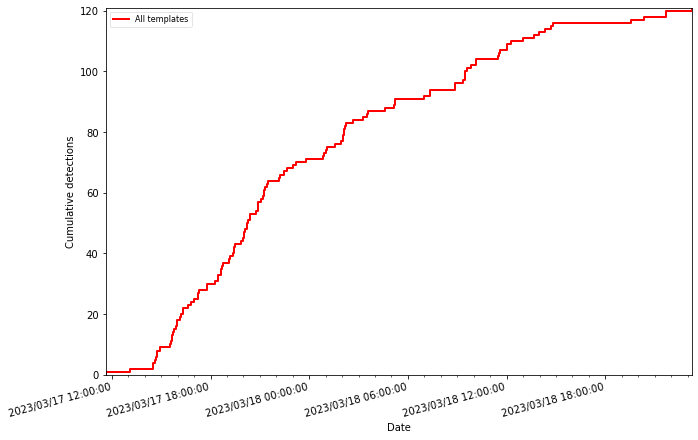

In [16]:
party.plot(plot_grouped=True)

## Note on concurrent processing

As of EQcorrscan versions > 0.4.4, detect methods support concurrent processing
of intermediate steps in the matched-filter process when running multiple
chunks of data (e.g. when `endtime - starttime > process_len`). By default this
is disabled as it does increase memory use. However, for cases when downloading
data from a client is a major bottleneck, or processing data is slow (e.g. when you
have limited CPU threads available, but do have a GPU for the FMF correlation
backend), and can cope with the extra memory requirements, this can be much faster.

To see examples of the speed-ups and memory consumption, look at the benchmarks
in the pull-request [here](https://github.com/eqcorrscan/EQcorrscan/pull/544).

To enable concurrent processing, use the `concurrent_processing` argument
for `.client_detect` or `.detect` methods on `Tribe` objects.